In [1]:
#Import necessary tools
#DF Imports
import pandas as pd
import numpy as np

#Viz imports
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns


#Modeling imports
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB, ComplementNB
from scipy import stats
from sklearn.svm import LinearSVC
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import random
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

#Eval imports
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss, mean_squared_error, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score


print("Setup Complete!")

Setup Complete!


## Import Data

In [2]:
df = pd.read_csv('wine.csv', index_col = 0)

In [3]:
#Look at the head of the data to get a feel for what information is contained and how it's laid out
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


## Pre-processing

In [4]:
#Check the shape of the data to get a feel for how large it is.
df.shape

(129971, 13)

With relatively few columns there really isn't much to drop. We'll keep all columns for now just in case they end up being useful to our analysis.

Now let's take a little bit closer look at some of the descriptions to get a feel for what kind of verbiage we're working with. Ultimately, the plan is to try to use these descriptions to try and predict a wine's varietal and country of origin.

In [5]:
df.description[0]

"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity."

In [6]:
df.description[1]

"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016."

Next, let's look at what all NA data we have

In [7]:
df.isna().sum()

country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

That's quite a bit of NA's but since our analysis is primarily concerned with price, description, and points it looks like we can probably do by just dropping observations that have NaN price. This will keep us in the range of ~1.2m observations vs. ~292k if we dropped all NA values.

In [8]:
#Drop NaN price obs
df = df.dropna(subset = ['price'])

Next, let's check for dupliates

In [9]:
df.duplicated().value_counts()

False    111593
True       9382
dtype: int64

Looks like we have some duplicates, time to drop them

In [10]:
df = df.drop_duplicates()

In [11]:
df.duplicated().value_counts()

False    111593
dtype: int64

In [12]:
df.dtypes

country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object

Next, let's bin wines by price. We'll preserve the original points column in case we want to do some regression or use a model that works well with numerical values but just add on a column with the following point ranges, ratings categories were retrieved from Winefolly

 50-59: undrinkable
 60-69: flawed
 70-79: average
 80-84: above average
 85-90: good
 90-94: superior
 95-100: benchmark


In [13]:
def bin_points(row):
    if row['points'] < 60:
        return "undrinkable"
    if row['points'] < 70 and row['points'] >= 60:
        return "flawed"
    if row['points'] < 80 and row['points'] >= 70:
        return 'average'
    if row['points'] < 85 and row['points'] >= 80:
        return 'above average'
    if row['points'] < 90 and row['points'] >= 85:
        return 'good'
    if row['points'] < 95 and row['points'] >= 90:
        return 'superior'
    if row['points'] >= 95:
        return 'benchmark'
      

In [14]:
#Call our categorization function on each row of the data frame
df['points_cat'] = df.apply(lambda row: bin_points(row), axis = 1)

In [15]:
#Check to make sure our new binned column is present
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,points_cat
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,good
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,good
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,good
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,good
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,good


Now that we know it's there, let's compare the value counts of the category and summary statistics of the original points values

In [16]:
df['points_cat'].value_counts()

good             57959
superior         39932
above average    11512
benchmark         2190
Name: points_cat, dtype: int64

In [17]:
df['points'].describe()

count    111593.000000
mean         88.413969
std           3.098767
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

It looks like there are no errors with mins or maxes and things generally line up so it seems that our function worked as expected.

Since we know that one of our numerical variables doesn't have any outliers, it's time to check the other. Let's take a look at price

In [18]:
z = np.abs(stats.zscore(df['price']))

In [19]:
outliers = np.where(z>3)

In [20]:
print(outliers)

(array([   268,    319,    320, ..., 111083, 111350, 111351]),)


It looks like we have a number outliers. Since we're not planning to use price at the moment we'll leave them be and clean them up in the event that we decide to use it in the future.

# Exploratory analysis and visualization

Time to start looking through our data and check whether there's anything additional that needs to be cleaned up or might be useful to know in our modeling

## Points

In [21]:
#Summary statistics for points
df['points'].describe()

count    111593.000000
mean         88.413969
std           3.098767
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

In [22]:
df['points'].median()

88.0

In [23]:
df['points'].mode()

0    87
dtype: int64

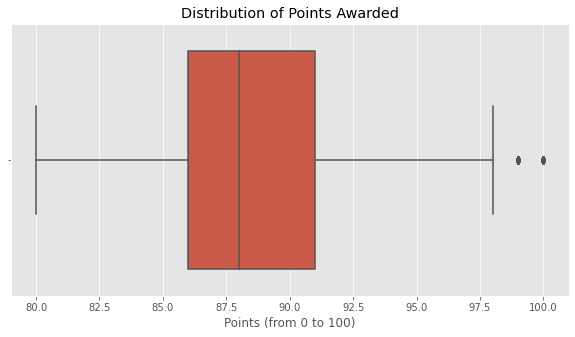

In [24]:
#Visualize the distribution of points
plt.figure(figsize = (10,5))
plt.style.use('ggplot')

ax = sns.boxplot(x = 'points', data = df)
ax.set(title = 'Distribution of Points Awarded', xlabel = 'Points (from 0 to 100)' )
plt.savefig('Points_distribution.png', bbox_inches = 'tight')


In [25]:
df['points_cat'].value_counts()

good             57959
superior         39932
above average    11512
benchmark         2190
Name: points_cat, dtype: int64

In [26]:
df['points_cat'].value_counts(normalize = True)

good             0.519378
superior         0.357836
above average    0.103161
benchmark        0.019625
Name: points_cat, dtype: float64

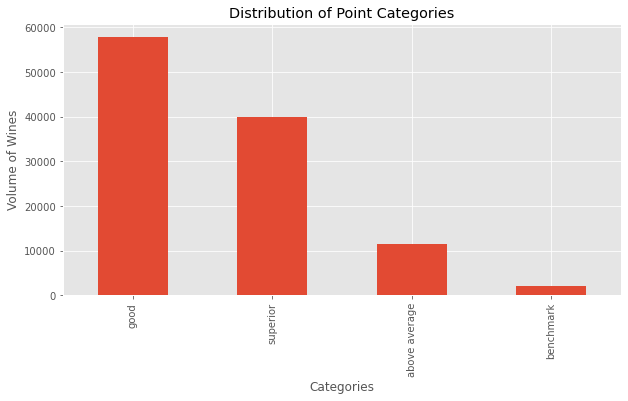

In [27]:
plt.figure(figsize = (10,5))
#plt.xticks(rotation = 50)
plt.style.use('ggplot')

df.groupby('points_cat').size().nlargest().plot(kind = 'bar').set(title = 'Distribution of Point Categories', xlabel = 'Categories', ylabel = 'Volume of Wines')
plt.savefig('points_cat.png', bbox_inches = 'tight')

## Geographic Provenance

Let's start off by looking at country and then we'll look at more specific regions

In [28]:
df['country'].value_counts()

US                        50238
France                    16286
Italy                     15506
Spain                      6049
Portugal                   4502
Chile                      4130
Argentina                  3501
Austria                    2536
Australia                  2169
Germany                    1951
New Zealand                1240
South Africa               1195
Israel                      453
Greece                      427
Canada                      224
Bulgaria                    132
Hungary                     128
Romania                     102
Uruguay                      98
Turkey                       81
Georgia                      74
Slovenia                     70
Mexico                       68
Croatia                      68
England                      59
Moldova                      56
Brazil                       44
Lebanon                      32
Morocco                      24
Peru                         16
Ukraine                      14
Czech Re

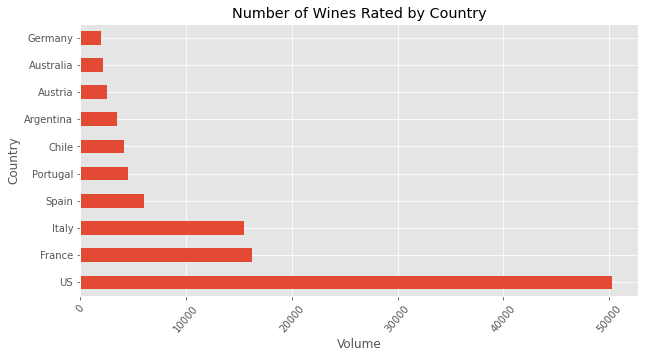

In [29]:
#That's a lot to take in, let's start by visualizing the top ten countries
plt.figure(figsize = (10,5))
plt.xticks(rotation = 50)
plt.style.use('ggplot')

df.groupby('country').size().nlargest(10).plot(kind = 'barh').set(title = 'Number of Wines Rated by Country', xlabel = 'Volume', ylabel = 'Country')
plt.savefig('country1.png', bbox_inches = 'tight')

In [30]:
##plt.figure(figsize = (10,5))
#plt.xticks(rotation = 50)
##plt.style.use('ggplot')

#df['country'].groupby('country').nlargest(10).plot(kind = 'bar').set(title = 'Distribution of Point Categories', xlabel = 'Categories', ylabel = 'Volume of Wines')
#plt.savefig('points_cat.png', bbox_inches = 'tight')
#plt.show()

In [31]:
df['province'].value_counts().describe()

count      422.000000
mean       264.308057
std       1754.588368
min          1.000000
25%          3.000000
50%         10.000000
75%         47.250000
max      33526.000000
Name: province, dtype: float64

Looks like there are quite a few... let's look at the top 25

In [32]:
print(df.groupby('province').size().nlargest(10))

province
California          33526
Washington           7913
Oregon               4917
Tuscany              4688
Bordeaux             3692
Northern Spain       3503
Mendoza Province     3001
Burgundy             2872
Piedmont             2833
New York             2444
dtype: int64


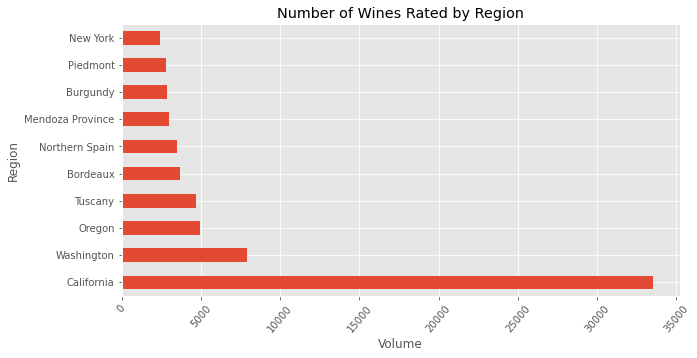

In [33]:
plt.figure(figsize = (10,5))
plt.xticks(rotation = 50)
plt.style.use('ggplot')

df.groupby('province').size().nlargest(10).plot(kind = 'barh').set(title = 'Number of Wines Rated by Region', xlabel = 'Volume', ylabel = 'Region')
plt.savefig('region1.png', bbox_inches = 'tight')

## Grape varietal


In [34]:
#Get an overview of the different varietals that were related
df['variety'].value_counts()

Pinot Noir                  11835
Chardonnay                  10238
Cabernet Sauvignon           8763
Red Blend                    7809
Bordeaux-style Red Blend     4958
                            ...  
Ondenc                          1
Sercial                         1
Vermentino Nero                 1
Caprettone                      1
Syrah-Bonarda                   1
Name: variety, Length: 697, dtype: int64

In [35]:
#It looks like there are quite a few- let's see how many there are in total
df['variety'].value_counts().size

697

In [36]:
#That is a lot of different varietals- let's look at the top 25
df['variety'].value_counts().nlargest(25)

Pinot Noir                  11835
Chardonnay                  10238
Cabernet Sauvignon           8763
Red Blend                    7809
Bordeaux-style Red Blend     4958
Riesling                     4572
Sauvignon Blanc              4403
Syrah                        3778
Rosé                         2951
Merlot                       2856
Zinfandel                    2524
Malbec                       2391
Sangiovese                   2163
Nebbiolo                     2159
Portuguese Red               2028
White Blend                  2004
Sparkling Blend              1849
Tempranillo                  1651
Rhône-style Red Blend        1283
Pinot Gris                   1268
Cabernet Franc               1196
Champagne Blend              1134
Grüner Veltliner             1019
Pinot Grigio                  934
Viognier                      911
Name: variety, dtype: int64

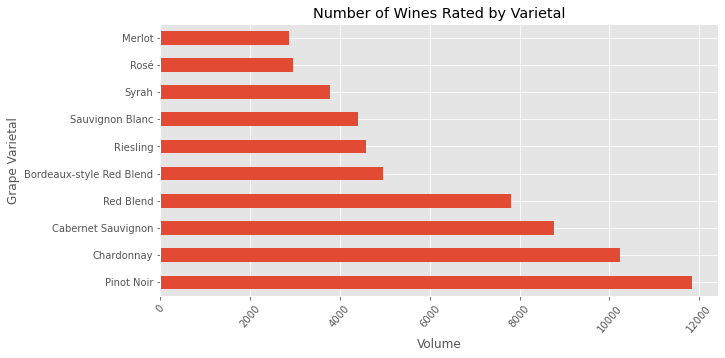

In [37]:
plt.figure(figsize = (10,5))
plt.xticks(rotation = 50)
plt.style.use('ggplot')

df.groupby('variety').size().nlargest(10).plot(kind = 'barh').set(title = 'Number of Wines Rated by Varietal', xlabel = 'Volume', ylabel = 'Grape Varietal')
plt.savefig('varietal1.png', bbox_inches = 'tight')

## Descriptive Language

Since the predictor variable is going to be the use of words in determining points, let's take a look at the frequency of different words in tasters' description

In [38]:
#Done with the assistance of data camp's tutorial on creating wordclouds
text = " ".join(review for review in df.description)
print ("There are {} words in the combination of all review.".format(len(text)))

There are 27393141 words in the combination of all review.


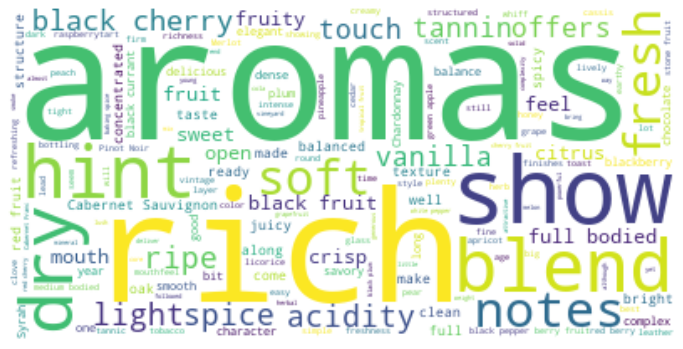

In [39]:
# Create stopword list:
plt.figure(figsize = (12, 9))
stopwords = set(STOPWORDS)
stopwords.update(["drink", "now", "finish", "note", 'nose', 'give', 'offer', 'aroma', 'palate',  "wine", "flavor", "flavors"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('descripto.png', bbox_inches = 'tight')

This wordcloud is fine but it doesn't necessarily give us any additional understanding of what certain words might imply or represent. Let's dive a little bit deeper into that.

In [40]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english')

In [41]:
tfidf_vector = tfidf_vectorizer.fit_transform(df['description'])
tfidf_vector

<111593x29967 sparse matrix of type '<class 'numpy.float64'>'
	with 2647286 stored elements in Compressed Sparse Row format>

In [42]:
tfidf_df = pd.DataFrame(tfidf_vector.toarray(), columns=tfidf_vectorizer.get_feature_names())
tfidf_df

,000,008,01,02,03,030,035,04,04s,05,...,émilion,étoile,été,öküzgözü,über,überaromatic,überbest,ürzig,ürziger,žilavka
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
# Get top n tfidf values in row and return them with their corresponding feature names.
def top_tfidf_feats(row, features, top_n=25):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [44]:
# Top tfidf features in specific document (matrix row)
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [45]:
df.loc[1]['description']

"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016."

In [46]:
top_feats_in_doc(tfidf_vector,tfidf_vectorizer.get_feature_names(),0,10)

,feature,tfidf
0,freshened,0.451147
1,filled,0.337542
2,certainly,0.314516
3,drinkable,0.310842
4,better,0.279086
5,2016,0.266123
6,structured,0.220477
7,smooth,0.203566
8,firm,0.193004
9,fruity,0.191156


In [47]:
#Let's start with a function that lets us look at the top words in a doc and their TF-IDF scores
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [48]:
top_mean_feats(tfidf_vector,tfidf_vectorizer.get_feature_names(),top_n=15)

,feature,tfidf
0,wine,0.016851
1,red,0.016542
2,black,0.016372
3,ripe,0.015931
4,berry,0.014820
5,dry,0.014777
6,fresh,0.014657
7,spice,0.014249
8,soft,0.014133
9,rich,0.013916


In [49]:
def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [50]:
dfs = top_feats_by_class(tfidf_vector,df['points_cat'],tfidf_vectorizer.get_feature_names() )

In [51]:
# Plot the data frames returned by the function plot_tfidf_classfeats().
def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(30, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#005035')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
        plt.savefig('classfeats.png', bbox_inches = 'tight')

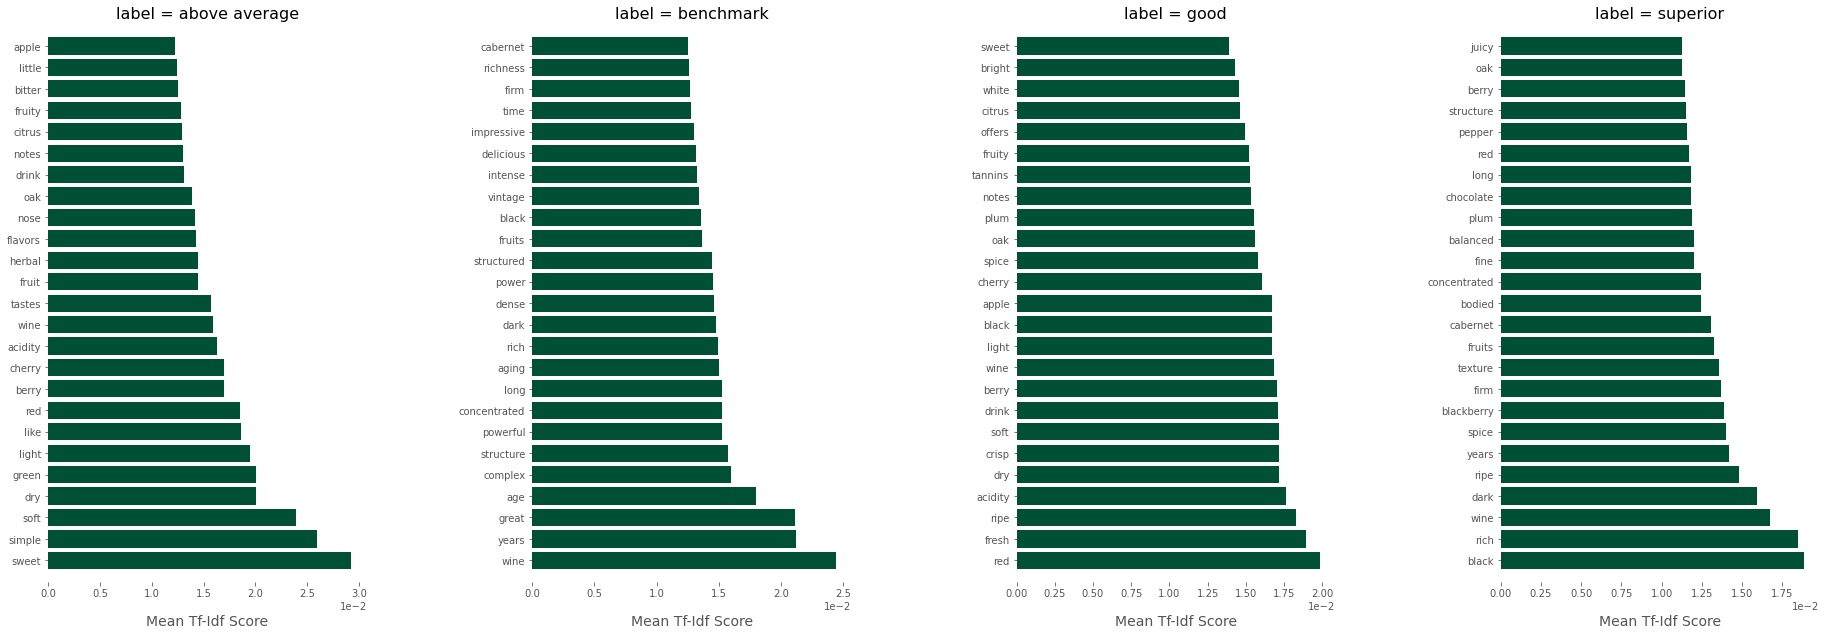

In [52]:
plot_tfidf_classfeats_h(dfs)

## Modeling

Let's start by checking our baseline for the target variable

In [53]:
df['points_cat'].value_counts(normalize = True)

good             0.519378
superior         0.357836
above average    0.103161
benchmark        0.019625
Name: points_cat, dtype: float64

To produce a meaningful model we'll need to exceed an accuracy of the most frequently occurring category. In our case that means we'll need to beat out the 52.7% that the 'good' category accounts for. 

In [54]:
#Create training and testing split at 70/30
train, test = train_test_split(df, test_size =0.3, random_state = 1888)

In [55]:
#Check our training columns for reference
train.columns

Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title',
       'variety', 'winery', 'points_cat'],
      dtype='object')

In [56]:
#Check the data set to verify that no records are missing
print('DF shape:', df.shape)
print('Train shape: ',train.shape)
print('Test shape: ', test.shape)

DF shape: (111593, 14)
Train shape:  (78115, 14)
Test shape:  (33478, 14)


In [57]:
#Set up our training sets with description as the IV and the quality category as the dependent value
x_train = train['description']
y_train = train['points_cat']

In [58]:
#Set up our testing sets with description as the IV and the quality category as the dependent value
x_test = test['description']
y_test = test['points_cat']

In [59]:
#Vectorize description for the training and testing sets
vec = TfidfVectorizer(ngram_range = (1,2), stop_words = 'english')
vec.fit(list(x_train) + list(x_test))
x_train_vectorized = vec.transform(x_train)
x_test_vectorized = vec.transform(x_test)

## SVM

In [60]:
#Model using SVM
svm = LinearSVC()
svm.fit(x_train_vectorized, y_train)

LinearSVC()

In [61]:
svm_predict = svm.predict(x_test_vectorized)

In [62]:
print(classification_report(y_test, svm_predict))

               precision    recall  f1-score   support

above average       0.75      0.41      0.53      3486
    benchmark       0.56      0.01      0.03       666
         good       0.73      0.82      0.78     17298
     superior       0.73      0.74      0.73     12028

     accuracy                           0.73     33478
    macro avg       0.69      0.50      0.52     33478
 weighted avg       0.73      0.73      0.72     33478



## Multinomial Naive Bayes

In [63]:
nb_model = MultinomialNB() # default params - MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
nb_model.fit(x_train_vectorized, y_train)

MultinomialNB()

In [64]:
print(nb_model.score(x_test_vectorized,y_test))

0.6287113925563056


In [65]:
y_predicted = nb_model.predict(x_test_vectorized)
ypred = pd.crosstab(y_test, y_predicted, rownames = ['Actual'], colnames = ['Predicted'])
ypred['Total'] = ypred.sum(axis=1) 
ypred.loc['Total'] = ypred.sum()
ypred

Predicted,good,superior,Total
Actual,,,
above average,3480,6,3486
benchmark,127,539,666
good,16865,433,17298
superior,7845,4183,12028
Total,28317,5161,33478


Uh oh! We noticed that some of the less frequently occurring classes aren't represented in the model's predictions. Let's take a look an value counts by volume instead of percentage and see what they look like.

In [66]:
train['points_cat'].value_counts()

good             40661
superior         27904
above average     8026
benchmark         1524
Name: points_cat, dtype: int64


It looks like we're going to need to upsample above average and benchmark to have them be adequately represented in our model. We'll upsample above average by 150% and benchmark by 1000%. Normally we'd go back and do this upstream in the code but for the sake of sharing what we'll learned we'll preserve existing code for context.

## Upsampling

In [67]:
#We'll start off by resampling the above average category
to_resample = train.loc[(train['points_cat'] == 'above average')]

Above average accounts for 8244 observations in the original training set. To upsample it by 150% we'll want to bring it 12366 - 8244 = 4022 additional observations.

In [68]:
our_resample = to_resample.sample(n = 4022, replace = True)

In [69]:
train_rebal = pd.concat([train, our_resample])

In [70]:
train_rebal['points_cat'].value_counts()

good             40661
superior         27904
above average    12048
benchmark         1524
Name: points_cat, dtype: int64

Looks good, now let's do the same for benchmark. With 1544 original observations we'll bring it to 15440 total which means adding 13896 observations.

In [71]:
to_resample1 = train.loc[(train['points_cat'] == 'benchmark')]

In [72]:
our_resample1 = to_resample1.sample(n = 13896, replace = True )

In [73]:
train_rebal = pd.concat([train_rebal, our_resample1])

In [74]:
train_rebal['points_cat'].value_counts()

good             40661
superior         27904
benchmark        15420
above average    12048
Name: points_cat, dtype: int64

Okay! We've got our resampling done. Let's look at normalized value counts one more time to see what our updated baseline is.

In [75]:
train_rebal['points_cat'].value_counts(normalize = True)

good             0.423407
superior         0.290567
benchmark        0.160570
above average    0.125457
Name: points_cat, dtype: float64

In [76]:
#Set up our training sets with description as the IV and the quality category as the dependent value
x_train = train_rebal['description']
y_train = train_rebal['points_cat']

In [77]:
#Set up our testing sets with description as the IV and the quality category as the dependent value
x_test = test['description']
y_test = test['points_cat']

In [78]:
#Vectorize description for the training and testing sets
vec = TfidfVectorizer(ngram_range = (1,2), stop_words = 'english')
vec.fit(list(x_train) + list(x_test))
x_train_vectorized = vec.transform(x_train)
x_test_vectorized = vec.transform(x_test)

### SVM Take 2

In [79]:
#Model using SVM
svm = LinearSVC()
svm.fit(x_train_vectorized, y_train)

LinearSVC()

In [80]:
#Print our svm score without cross validation
print(svm.score(x_train_vectorized, y_train))

0.9985525808836546


In [81]:
#Establish k = 5
kfold = KFold(n_splits=10, random_state=0, shuffle=True)

In [82]:
svm_cv_scores = cross_val_score(svm, x_train_vectorized, y_train, cv=kfold)
print("SVM cross validation scores with k=10: ", svm_cv_scores)
print("Average score of all folds:",svm_cv_scores.mean())

SVM cross validation scores with k=10:  [0.80372761 0.79904207 0.80539359 0.80620639 0.80860148 0.80245757
 0.80776841 0.80516505 0.80610226 0.80735187]
Average score of all folds: 0.8051816290402446


In [83]:
svm_predict = svm.predict(x_test_vectorized)

In [84]:
print(classification_report(y_test, svm_predict))

               precision    recall  f1-score   support

above average       0.72      0.45      0.55      3486
    benchmark       0.53      0.10      0.16       666
         good       0.73      0.82      0.77     17298
     superior       0.73      0.72      0.73     12028

     accuracy                           0.73     33478
    macro avg       0.68      0.52      0.55     33478
 weighted avg       0.73      0.73      0.72     33478



In [97]:
#Create function to plot our confusion matrix

def plot_confusion_matrix_SVM(Y_test, Y_preds):
    conf_mat = confusion_matrix(Y_test, Y_preds)
    
    #print(conf_mat)
    fig = plt.figure(figsize=(10,10))
    plt.matshow(conf_mat, cmap=plt.cm.Blues, fignum=1)
    plt.yticks(range(4), ['above average', 'benchmark', 'good', 'superior'], rotation = 20)
    plt.xticks(range(4), ['above average', 'benchmark', 'good', 'superior'], rotation = 20)
    plt.title("Confusion Matrix for M")
    plt.xlabel("Predicted")
    ax.xaxis.set_label_position('top') 
    plt.ylabel("Actual")

    plt.colorbar();
    for i in range(4):
        for j in range(4):
            plt.text(i-0.2,j+0.1, str(conf_mat[j, i]), color='tab:red')
            
    plt.savefig('svm_cm.png', bbox_inches = 'tight')

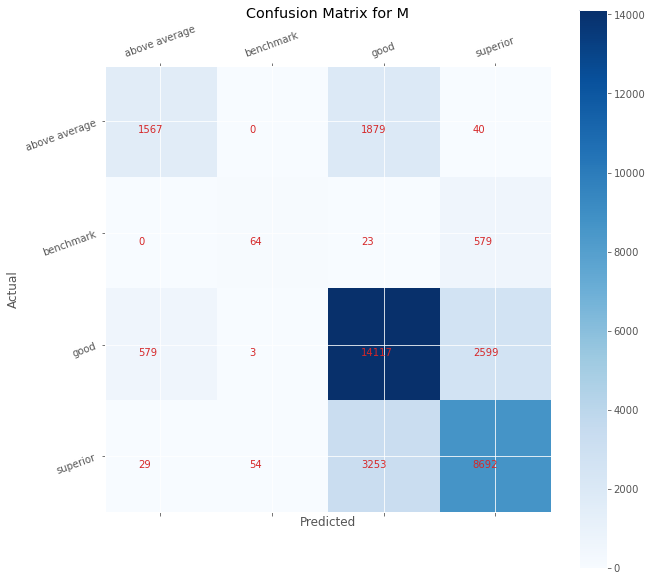

In [98]:
plot_confusion_matrix_SVM(y_test, svm_predict)

It looks like we got some pretty meaningful improvement thanks to the rebalancing.

### MNNB Take 2

In [87]:
# 5 folds selected

nb_model = MultinomialNB() # default params - MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
nb_model.fit(x_train_vectorized, y_train)
nb_scores = cross_val_score(nb_model, x_train_vectorized, y_train, cv=kfold)

In [88]:
#Look at the score without cross validation
print(nb_model.score(x_train_vectorized, y_train))

0.756604500536274


In [89]:
# Output the accuracy. Calculate the mean and std across all folds. 
print("Accuracy: %.3f%% (%.3f%%)" % (nb_scores.mean()*100.0, nb_scores.std()*100.0))
print("Average score of all folds:",nb_scores.mean())

Accuracy: 65.646% (0.403%)
Average score of all folds: 0.6564617978476894


In [90]:
#Create predictions from mn nb model to feed into classification report
mnb_predict = nb_model.predict(x_test_vectorized)

In [91]:
#Print classification report
print(classification_report(y_test, mnb_predict))

               precision    recall  f1-score   support

above average       1.00      0.01      0.02      3486
    benchmark       0.64      0.08      0.13       666
         good       0.59      0.98      0.74     17298
     superior       0.82      0.34      0.48     12028

     accuracy                           0.63     33478
    macro avg       0.76      0.35      0.34     33478
 weighted avg       0.72      0.63      0.56     33478



In [92]:
#Let's take a look at the contingency table for our NB model
y_predicted = nb_model.predict(x_test_vectorized)
ypred = pd.crosstab(y_test, y_predicted, rownames = ['Actual'], colnames = ['Predicted'])
ypred['Total'] = ypred.sum(axis=1) 
ypred.loc['Total'] = ypred.sum()
ypred

Predicted,above average,benchmark,good,superior,Total
Actual,,,,,
above average,28,0,3453,5,3486
benchmark,0,50,134,482,666
good,0,0,16871,427,17298
superior,0,28,7933,4067,12028
Total,28,78,28391,4981,33478


In [93]:
#Create function to plot our confusion matrix

def plot_confusion_matrix(Y_test, Y_preds):
    conf_mat = confusion_matrix(Y_test, Y_preds)
    
    #print(conf_mat)
    fig = plt.figure(figsize=(10,10))
    plt.matshow(conf_mat, cmap=plt.cm.Blues, fignum=1)
    plt.yticks(range(4), ['above average', 'benchmark', 'good', 'superior'], rotation = 20)
    plt.xticks(range(4), ['above average', 'benchmark', 'good', 'superior'], rotation = 20)
    plt.title("Confusion Matrix for Multinomial Naive Bayes Model")
    plt.xlabel("Predicted")
    ax.xaxis.set_label_position('top') 
    plt.ylabel("Actual")

    plt.colorbar();
    for i in range(4):
        for j in range(4):
            plt.text(i-0.2,j+0.1, str(conf_mat[j, i]), color='tab:red')


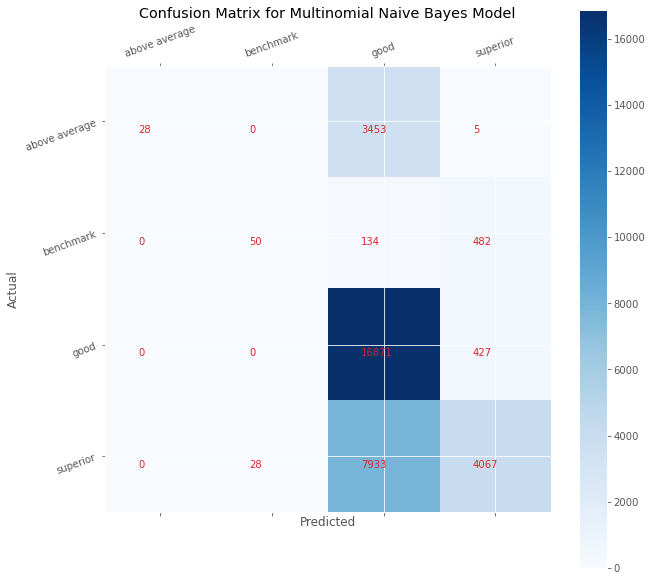

In [94]:
plot_confusion_matrix(y_test, nb_model.predict(x_test_vectorized))

### Tree Modeling

In [95]:
#Create cart model using max 15 nodes
cart01 = DecisionTreeClassifier(criterion = "gini", max_leaf_nodes=15).fit(x_train_vectorized,y_train)


In [96]:
#Create our c50 model using max 15 nodes
c50_01 = DecisionTreeClassifier(criterion="entropy",max_leaf_nodes=15).fit(x_train_vectorized,y_train)

In [98]:
print("Training scores:")
print("CART: ", cart01.score(x_train_vectorized,y_train))
print('C5.0 ', c50_01.score(x_train_vectorized,y_train))
print("----------------")
print("Test scores:")
print("CART: ", cart01.score(x_test_vectorized,y_test))
print('C5.0 ', c50_01.score(x_test_vectorized,y_test))

Training scores:
CART:  0.48678058584028405
C5.0  0.48064727749835995
Random Forest  0.5643372590671957
----------------
Test scores:
CART:  0.5983033634028317
C5.0  0.5879682179341658
Random Forest  0.9999701296373738


In [99]:
cart_cv_scores = cross_val_score(cart01, x_train_vectorized, y_train, cv=kfold)
c50_cv_scores = cross_val_score(c50_01, x_train_vectorized, y_train, cv = kfold)

In [100]:
#Create predictions for classification report
y_pred_test_cart = cart01.predict(x_test_vectorized)
y_pred_test_c50 = c50_01.predict(x_test_vectorized)

In [104]:
print("Cart cross validation scores with k=10: ", cart_cv_scores)
print("Average score of all folds:",cart_cv_scores.mean())
print("Cart C50 validation scores with k=10: ", c50_cv_scores)
print("Average score of all folds:",c50_cv_scores.mean())

Cart cross validation scores with k=10:  [0.48875469 0.49656393 0.492399   0.49765698 0.49494949 0.48172446
 0.4952619  0.49422056 0.49078413 0.48859731]
Average score of all folds: 0.49209124526067205
Cart C50 validation scores with k=10:  [0.48521449 0.49479384 0.48740108 0.49422056 0.49036759 0.47880871
 0.48974279 0.49349162 0.48755597 0.48411955]
Average score of all folds: 0.48857161918762104


In [102]:
print("CART Classification Report\n", classification_report(y_test, y_pred_test_cart, zero_division = 0))

CART Classification Report
                precision    recall  f1-score   support

above average       0.78      0.04      0.08      3486
    benchmark       0.00      0.00      0.00       666
         good       0.60      0.81      0.69     17298
     superior       0.60      0.49      0.54     12028

     accuracy                           0.60     33478
    macro avg       0.49      0.34      0.33     33478
 weighted avg       0.60      0.60      0.56     33478



In [103]:
print("C50 Classification Report\n", classification_report(y_test, y_pred_test_c50, zero_division = 0))

C50 Classification Report
                precision    recall  f1-score   support

above average       0.56      0.06      0.11      3486
    benchmark       0.00      0.00      0.00       666
         good       0.58      0.85      0.69     17298
     superior       0.62      0.40      0.48     12028

     accuracy                           0.59     33478
    macro avg       0.44      0.33      0.32     33478
 weighted avg       0.58      0.59      0.54     33478

